In [1]:
from glob import glob
import pandas as pd
import numpy as np

In [100]:
files1 = glob('training_setA/*')
files2 = glob('training_setB/*')
files = files1+files2

In [101]:
len(files)

40336

In [122]:
aggr = []
for file in files:
    patient = file.split('/')[1].split('.')[0]
    data = pd.read_csv(file,sep = '|')
    start = data[['HR','O2Sat','SBP','MAP','DBP','Resp']].max()
    end = data[['HR','O2Sat','SBP','MAP','DBP','Resp']].min()
    var = data[['HR','O2Sat','SBP','MAP','DBP','Resp']].var()
    temp = start.append(end).append(var).to_list()
    Age = data.loc[0,'Age']
    Gender = data.loc[0,'Gender']
    Unit1 = data.loc[0,'Unit1']
    Unit2 = data.loc[0,'Unit2']
    ## Assuming this field doesn't change for a patient
    HospAdmTime = data.loc[0,'HospAdmTime']

    ICULOS = data.iloc[-1,39]        #We can also use length of data

    Sepsis = int(any(data['SepsisLabel']==1))
    
    aggr.append(temp+[patient,Age, Gender, Unit1, Unit2, HospAdmTime, ICULOS, Sepsis])

In [123]:
aggr = pd.DataFrame(aggr,columns = ['Max_HR','Max_O2Sat','Max_SBP','Max_MAP','Max_DBP','Max_Resp',
                                    'min_HR','min_O2Sat','min_SBP','min_MAP','min_DBP','min_Resp',
                                    'V_HR','V_O2Sat','V_SBP','V_MAP','V_DBP','V_Resp','patient_id',
                                    'Age','Gender','Unit1','Unit2','HospAdmTime','ICULOS','SepsisLabel']).copy()
aggr.head()

,Max_HR,Max_O2Sat,Max_SBP,Max_MAP,Max_DBP,Max_Resp,min_HR,min_O2Sat,min_SBP,min_MAP,...,V_DBP,V_Resp,patient_id,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,75.0,100.0,NaN,101.00,NaN,14.5,61.0,98.0,NaN,63.0,...,NaN,0.066964,p016161,47.20,1,NaN,NaN,-0.01,10,1
1,80.0,100.0,127.0,89.00,84.0,26.0,65.0,98.0,86.0,67.0,...,49.703557,22.516798,p019252,80.34,0,0.0,1.0,-2.97,24,0
2,92.0,100.0,135.0,96.00,NaN,20.0,66.0,93.0,100.0,60.0,...,NaN,6.051220,p006372,84.22,0,1.0,0.0,-0.03,48,0
3,84.0,100.0,148.0,120.00,78.0,28.0,68.0,93.0,79.0,58.0,...,53.552500,17.196441,p009041,76.93,1,0.0,1.0,-1.69,40,0
4,107.0,100.0,183.0,112.33,NaN,18.5,55.0,96.0,82.5,55.0,...,NaN,2.792359,p010510,56.10,1,0.0,1.0,-767.78,49,0


In [128]:
aggr = aggr.fillna(aggr.median())
X = aggr.drop(columns =['SepsisLabel','patient_id'])
y = aggr['SepsisLabel']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

from sklearn.ensemble import GradientBoostingClassifier
zero = len(y_train[y_train== 0])
zero
one = len(y_train[y_train== 1])
one
w0=(one/zero)*2
w1=1
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = w0
sample_weights[y_train == 1] = w1


GBC=GradientBoostingClassifier(n_estimators=100,learning_rate = 0.1, subsample=0.5)
GBC.fit(X_train, y_train,sample_weights)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [131]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
def get_scores(y_true, y_pred, y_prob):
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_prob)}")

In [132]:
print('Training score')
get_scores(y_train, GBC.predict(X_train),GBC.predict_proba(X_train)[:,1])

print('Test score')
get_scores(y_test, GBC.predict(X_test),GBC.predict_proba(X_test)[:,1])

Training score
Accuracy: 0.9445015052240128
Recall: 0.6748166259168704
Precision: 0.6047326906222612
ROC AUC: 0.9228301737070925
Test score
Accuracy: 0.9433931080076027
Recall: 0.657271702367531
Precision: 0.6047717842323651
ROC AUC: 0.9008339149263613


## joining all the data

In [3]:
data_full = pd.concat( (pd.read_csv(file,sep='|') for file in files),ignore_index=True )

In [4]:
#data2 = pd.concat( (pd.read_csv(file,sep='|') for file in files2),ignore_index=True )

In [5]:
#data_full = pd.concat([data1,data2],ignore_index=True)

In [6]:
data_full.tail()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
1552205,85.0,100.0,NaN,124.0,92.0,75.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,26.0,0,1.0,0.0,-0.19,41,0
1552206,103.0,100.0,36.5,120.0,93.0,75.0,31.0,NaN,NaN,NaN,...,NaN,NaN,NaN,26.0,0,1.0,0.0,-0.19,42,0
1552207,88.0,100.0,NaN,128.0,99.0,78.0,28.0,NaN,NaN,NaN,...,NaN,NaN,NaN,26.0,0,1.0,0.0,-0.19,43,0
1552208,101.0,100.0,NaN,126.0,93.0,71.0,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,26.0,0,1.0,0.0,-0.19,44,0
1552209,77.0,100.0,NaN,127.0,99.0,80.0,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,26.0,0,1.0,0.0,-0.19,45,0


In [7]:
count_NAs = data_full.isna().sum()
test = count_NAs/len(data_full)*100

In [8]:
list(test[test<40].index)

['HR',
 'O2Sat',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'Age',
 'Gender',
 'Unit1',
 'Unit2',
 'HospAdmTime',
 'ICULOS',
 'SepsisLabel']

In [9]:
data = data_full[list(test[test<40].index)]

In [11]:
data = data.fillna(data.mean())

In [12]:
data.head()

,HR,O2Sat,SBP,MAP,DBP,Resp,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,74.0,100.0,123.750465,101.0,63.830556,14.5,47.2,1,0.496571,0.503429,-0.01,3,1
1,72.0,98.0,123.750465,81.0,63.830556,14.5,47.2,1,0.496571,0.503429,-0.01,4,1
2,75.0,100.0,123.750465,83.0,63.830556,14.0,47.2,1,0.496571,0.503429,-0.01,5,1
3,63.0,100.0,123.750465,64.0,63.830556,14.0,47.2,1,0.496571,0.503429,-0.01,6,1
4,61.0,100.0,123.750465,66.0,63.830556,14.5,47.2,1,0.496571,0.503429,-0.01,7,1


In [13]:
# Select target
y = data.SepsisLabel
# Select predictors
X = data.iloc[:,0:12]
X.shape

(1552210, 12)

In [14]:
X.head()

,HR,O2Sat,SBP,MAP,DBP,Resp,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,74.0,100.0,123.750465,101.0,63.830556,14.5,47.2,1,0.496571,0.503429,-0.01,3
1,72.0,98.0,123.750465,81.0,63.830556,14.5,47.2,1,0.496571,0.503429,-0.01,4
2,75.0,100.0,123.750465,83.0,63.830556,14.0,47.2,1,0.496571,0.503429,-0.01,5
3,63.0,100.0,123.750465,64.0,63.830556,14.0,47.2,1,0.496571,0.503429,-0.01,6
4,61.0,100.0,123.750465,66.0,63.830556,14.5,47.2,1,0.496571,0.503429,-0.01,7


In [15]:
print(X.describe())

                 HR         O2Sat           SBP           MAP           DBP  \
count  1.552210e+06  1.552210e+06  1.552210e+06  1.552210e+06  1.552210e+06   
mean   8.458144e+01  9.719395e+01  1.237505e+02  8.240010e+01  6.383056e+01   
std    1.644688e+01  2.738418e+00  2.147167e+01  1.529056e+01  1.156364e+01   
min    2.000000e+01  2.000000e+01  2.000000e+01  2.000000e+01  2.000000e+01   
25%    7.400000e+01  9.600000e+01  1.090000e+02  7.200000e+01  5.800000e+01   
50%    8.458144e+01  9.719395e+01  1.237505e+02  8.240010e+01  6.383056e+01   
75%    9.400000e+01  9.900000e+01  1.350000e+02  9.000000e+01  6.700000e+01   
max    2.800000e+02  1.000000e+02  3.000000e+02  3.000000e+02  3.000000e+02   

               Resp           Age        Gender         Unit1         Unit2  \
count  1.552210e+06  1.552210e+06  1.552210e+06  1.552210e+06  1.552210e+06   
mean   1.872650e+01  6.200947e+01  5.592690e-01  4.965711e-01  5.034289e-01   
std    4.690489e+00  1.638622e+01  4.964749e-01  3.

In [16]:
X.median()

HR              84.581443
O2Sat           97.193955
SBP            123.750465
MAP             82.400100
DBP             63.830556
Resp            18.726498
Age             64.000000
Gender           1.000000
Unit1            0.496571
Unit2            0.503429
HospAdmTime     -6.030000
ICULOS          21.000000
dtype: float64

In [17]:
#Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
continuous_variables = ['HR','O2Sat','SBP','MAP','DBP','Resp','Age','HospAdmTime','ICULOS']
X[continuous_variables] = scaler.fit_transform(X[continuous_variables])

In [18]:
#Split train test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [19]:
from sklearn.linear_model import LogisticRegression
logitreg = LogisticRegression(solver = 'liblinear')
result = logitreg.fit(X_train, np.ravel(y_train))
# predict the output for test dataset
y_test_pred = logitreg.predict(X_test)
pd.Series(y_test_pred).value_counts()

0    465579
1        84
dtype: int64

In [20]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix
y_test_ar = np.array(y_test)
y_test_pred_ar = np.array(y_test_pred)
print("Accuracy:",accuracy_score(y_test_ar, y_test_pred_ar))
print("Precision:",precision_score(y_test_ar, y_test_pred_ar))
print("Recall:",recall_score(y_test_ar, y_test_pred_ar))
pd.DataFrame(confusion_matrix(y_test_ar,y_test_pred_ar),index=["Real_False", "Real_True"], columns=["Predict_False", "Predict_True"])

Accuracy: 0.9820170380725975
Precision: 0.16666666666666666
Recall: 0.001683096898292859


,Predict_False,Predict_True
Real_False,457275,70
Real_True,8304,14


In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
from sklearn.metrics import roc_curve, auc
probs = logitreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_ar, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve by giving appropriate names for title and axes. 
import matplotlib.pyplot as plt
plt.title('Logistic Regression ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [104]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=26)
model = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
pd.Series(y_test_pred).value_counts()

0    456208
1      9455
dtype: int64

In [105]:
y_test_ar = np.array(y_test)
y_test_pred_ar = np.array(y_test_pred)
print("Accuracy:",accuracy_score(y_test_ar, y_test_pred_ar))
print("Precision:",precision_score(y_test_ar, y_test_pred_ar))
print("Recall:",recall_score(y_test_ar, y_test_pred_ar))
pd.DataFrame(confusion_matrix(y_test_ar,y_test_pred_ar),index=["Real_False", "Real_True"], columns=["Predict_False", "Predict_True"])

Accuracy: 0.9765302375322926
Precision: 0.3619249074563723
Recall: 0.4113969704255831


,Predict_False,Predict_True
Real_False,451312,6033
Real_True,4896,3422


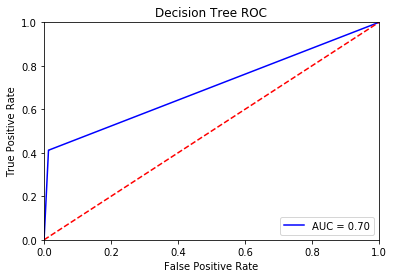

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_ar, preds)
roc_auc = auc(fpr, tpr)

plt.title('Decision Tree ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [23]:
from sklearn.ensemble import RandomForestClassifier
### Fit the classifier on the training data

clf = RandomForestClassifier(random_state=26)
model = clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
pd.Series(y_test_pred).value_counts()

/Users/Elisa/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0    464736
1       927
dtype: int64

In [24]:
y_test_ar = np.array(y_test)
y_test_pred_ar = np.array(y_test_pred)
print("Accuracy:",accuracy_score(y_test_ar, y_test_pred_ar))
print("Precision:",precision_score(y_test_ar, y_test_pred_ar))
print("Recall:",recall_score(y_test_ar, y_test_pred_ar))
pd.DataFrame(confusion_matrix(y_test_ar,y_test_pred_ar),index=["Real_False", "Real_True"], columns=["Predict_False", "Predict_True"])

Accuracy: 0.9835911377970764
Precision: 0.8651564185544768
Recall: 0.09641740803077663


,Predict_False,Predict_True
Real_False,457220,125
Real_True,7516,802


In [ ]:
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_ar, preds)
roc_auc = auc(fpr, tpr)

plt.title('Random Forest ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()